# PRIMERA PARTE

### Importamos las librerías necesarias para realizar la lectura de datos desde el data set y construir el modelo, además de importar el dataset1.xlsx

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Importando librerías para construir el modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix
# Importando el dataset
data = pd.read_excel('dataset1.xlsx')

# SEGUNDA PARTE

## Se generan los set de entradas, donde los X representan las carácteristica de cada muestra y los "y" representan los grupos a los cuales pertenecen

##### transformamos los nombres de las carreras en un vector de unos y ceros, con solo una asginación (one_hot_vector) y descartamos un genero, una de las carreras y uno de los colegios, ya que con su par o grupo generan multicolinealidad perfecta

In [93]:
X = data
X = X.join(pd.get_dummies(X['crr_Nom']))
X.drop(['INGENIERIA CIVIL AEROESPACIAL','crr_Nom','cluster','F', 'MUNICIPAL'],axis=1,inplace=True)
X = X.values

#### Al igual que en el caso anterior, transformamos los grupos en vectores de unos y ceros, con solo un 1 en cada vector

In [94]:
y = data.join(pd.get_dummies(data['cluster']))
y = y[['C1','C2','C3','C4']]
y = y.values

### En este punto se determinan los set de entrenamiento y de prueba, con una relación 80-20

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# TERCERA PARTE

## Se crea el modelo como una clase

#### En la primera parte del modelo (__init__)  determinamos cuantas capas tendremos y cuantas neuronas en cada nodo, además de los epochs y las dimensiones de los thetas para la regresión

#### En el apartado dos (__call__) Se crean los Bias (vector columna de unos) y se realizan las multiplicaciones correspondientes entre los features y los thetas correspondientes. En este punto se utiliza la función sigmoide en cada una de las capas y la función softmax para realizar la última asignación

#### Definimos train como el apartado donde se lleva a cabo la minimización de la función de perdida y se asignan los nuevos thetas a los anteriores.

#### luego en __name__ llamamos a l función con los valores de x e y asignados para el entrenamiento y se realiza el mismo, a posteriori se realiza la prueba con los parametros asignados para esto

In [82]:
class Model(object):
    def __init__(self, hidden1_nodes, hidden2_nodes,hidden3_nodes, hidden4_nodes,dim, epochs=1000):
        self.hidden1_nodes = hidden1_nodes #16
        self.hidden2_nodes = hidden2_nodes #16
        self.hidden3_nodes = hidden3_nodes #10
        self.hidden4_nodes = hidden4_nodes #8
        self.epochs = epochs
        samples, features = dim
        self.theta1 = tf.Variable(tf.random.normal([features+1,self.hidden1_nodes], dtype= tf.float64) ,name = "Theta1")
        self.theta2 = tf.Variable(tf.random.normal([self.hidden1_nodes+1,self.hidden2_nodes], dtype= tf.float64), name = "Theta2")
        self.theta3 = tf.Variable(tf.random.normal([self.hidden2_nodes+1,self.hidden3_nodes], dtype= tf.float64), name = "Theta3")
        self.theta4 = tf.Variable(tf.random.normal([self.hidden3_nodes+1,self.hidden4_nodes], dtype= tf.float64), name = "Theta4")

    def __call__(self, x):
        samples = x.shape[0]
        self.bias1 = tf.constant(1, dtype=tf.float64, shape=(samples,1), name='bias1')
        self.bias2 = tf.constant(1, dtype=tf.float64, shape=(samples,1), name='bias2')
        self.bias3 = tf.constant(1, dtype=tf.float64, shape=(samples,1), name='bias3')
        self.bias4 = tf.constant(1, dtype=tf.float64, shape=(samples,1), name='bias4')
        
        a0 = tf.concat([self.bias1,x],1, name='a0')
        
        z1 = tf.matmul(a0,self.theta1, name='z1')
        a1 = tf.concat([self.bias2,tf.sigmoid(z1)],1,name='a1')
        
        z2 = tf.matmul(a1,self.theta2, name='z2')
        a2 = tf.concat([self.bias3,tf.sigmoid(z2)],1,name='a2')
        
        z3 = tf.matmul(a2,self.theta3, name='z3')
        a3 = tf.concat([self.bias4,tf.sigmoid(z3)],1,name='a3')
        
        z4 = tf.matmul(a3,self.theta4, name='z4')
        a4 = tf.nn.softmax(z4, name='a4')
        return a4

    
    def train(self, inputs, outputs):
        theta1_hist, theta2_hist, theta3_hist, theta4_hist= [], [], [], []
        for epoch in range(self.epochs):
            learning_rate = 0.5
            with tf.GradientTape() as t:
                loss = Model.loss(outputs, self.predict(inputs))
                dThe1, dThe2, dThe3, dThe4 = t.gradient(loss, [self.theta1, self.theta2,self.theta3,self.theta4])
                self.theta1.assign_sub(learning_rate * dThe1)
                self.theta2.assign_sub(learning_rate * dThe2)
                self.theta3.assign_sub(learning_rate * dThe3)
                self.theta4.assign_sub(learning_rate * dThe4)
                theta1_hist.append(self.theta1.numpy())
                theta2_hist.append(self.theta2.numpy())
                theta3_hist.append(self.theta3.numpy())
                theta4_hist.append(self.theta4.numpy())
                
    def predict(self, x):
        return self.__call__(x)
    
    @staticmethod
    def loss(target_y, predicted_y):
        return tf.reduce_mean(-tf.reduce_sum(target_y*tf.math.log(predicted_y), axis=1), axis = 0, name='Cost_function'
                              
                              
if __name__ == "__main__": 
    x = tf.constant(X_train, dtype=tf.float64, name='features')
    y = tf.constant(y_train, dtype=tf.float64, name='cluster')
    xtest = tf.constant(X_test, dtype=tf.float64, name='features_test')
    cluster = Model(hidden1_nodes=16,hidden2_nodes=16,hidden3_nodes=10, hidden4_nodes=4, dim=x.shape)
    cluster.train(x,y)
    cluster.predict(xtest)

In [85]:
def to_one_and_ceros(coef):
    one_hot = np.zeros(coef.shape)
    coef_np = coef.values
    for i in range(coef.shape[0]):
        one_hot[i][np.argmax(coef_np[i])] = 1
    one_hot = pd.DataFrame(one_hot)
    return one_hot
    
def how_many(one_hot):
    return one_hot.sum()

def sum_prob(one_hot):
    coef = one_hot.values
    suma_prob=np.zeros((one_hot.shape[0],1))
    for i in range(one_hot.shape[0]):
        suma_prob[i]= np.sum(coef[i])
    return suma_prob

In [96]:
predicción = pd.DataFrame(cluster.predict(xtest).numpy())
coding=to_one_and_ceros(predicción)
cuenta = how_many(coding)

In [97]:
print(classification_report(y_test,coding))

              precision    recall  f1-score   support

           0       0.70      0.87      0.78       287
           1       0.75      0.81      0.78       708
           2       0.79      0.61      0.69       361
           3       0.82      0.68      0.74       218

   micro avg       0.76      0.76      0.76      1574
   macro avg       0.77      0.74      0.75      1574
weighted avg       0.76      0.76      0.75      1574
 samples avg       0.76      0.76      0.76      1574



In [88]:
multilabel_confusion_matrix(y_test,coding)

              precision    recall  f1-score   support

           0       0.70      0.87      0.78       287
           1       0.75      0.81      0.78       708
           2       0.79      0.61      0.69       361
           3       0.82      0.68      0.74       218

   micro avg       0.76      0.76      0.76      1574
   macro avg       0.77      0.74      0.75      1574
weighted avg       0.76      0.76      0.75      1574
 samples avg       0.76      0.76      0.76      1574



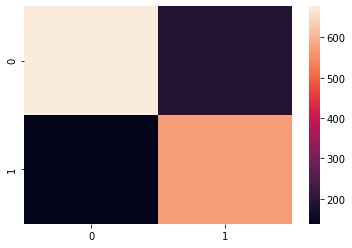

In [90]:
sns.heatmap(multilabel_confusion_matrix(y_test,coding)[])